##Connect to drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pwd
# Change directory
%cd ../content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
!pwd

/content
/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0


# Setup

### Libraries

In [3]:
import pandas as pd
import numpy as np
import zipfile
# NLTK
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
nltk.download('averaged_perceptron_tagger')
from matplotlib.gridspec import GridSpec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Import util functions

In [4]:
!pip install import-ipynb
import import_ipynb

#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%cd ./utils
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
module = drive.CreateFile({'id':'1pegou5Ag0hDIKk6Y1wS9uwegE6oBTfZJ'})
module.GetContentFile('DataPrep.ipynb')
import DataPrep 

/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0/utils
importing Jupyter notebook from DataPrep.ipynb


In [6]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0/utils')
execfile('utils/test.py')
hello()

/content/gdrive/MyDrive/Colab Notebooks/Kaggle/NLP0
Hello world


In [7]:
# Create data folder
#%mkdir data

#Data preparation


## Extract data

In [8]:
# Extract from zip file
# with zipfile.ZipFile("nlp-getting-started.zip", 'r') as zip_ref:
#     zip_ref.extractall("data")

In [9]:
# read in training data
data = pd.read_csv("data/train.csv")
data.reset_index(inplace=True)

In [10]:
# data info
print("Shape:",data.shape)
print("Columns:\n",data.columns)
print(data.head(5))
print("Missing volumes:\n",data.isna().sum())

Shape: (7613, 6)
Columns:
 Index(['index', 'id', 'keyword', 'location', 'text', 'target'], dtype='object')
   index  id keyword location  \
0      0   1     NaN      NaN   
1      1   4     NaN      NaN   
2      2   5     NaN      NaN   
3      3   6     NaN      NaN   
4      4   7     NaN      NaN   

                                                text  target  
0  Our Deeds are the Reason of this #earthquake M...       1  
1             Forest fire near La Ronge Sask. Canada       1  
2  All residents asked to 'shelter in place' are ...       1  
3  13,000 people receive #wildfires evacuation or...       1  
4  Just got sent this photo from Ruby #Alaska as ...       1  
Missing volumes:
 index          0
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


## Tokenize, tidy & reshape

### Tidy sentences

In [11]:
sent = data[['text','target']].copy()

In [12]:
my_stopwords = stopwords.words("english")
my_stopwords = my_stopwords + ['I','A','the','The','a']
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@#'

In [15]:
sent['clean_tweet'] = sent.text.apply(DataPrep.clean_tweet, args=[my_punctuation,my_stopwords,word_rooter])
sent['clean_tweet_root'] = sent.text.apply(DataPrep.clean_tweet, args=[my_punctuation,my_stopwords,word_rooter],root=True)
sent.head(5)

,text,target,clean_tweet,clean_tweet_root
0,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders c...,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,got sent photo rubi alaska smoke wildfir pour ...


### Tidy Words

In [13]:
# Tokenize words from twits and add them to a ds
#text = data.text
text = sent.clean_tweet
text_root = sent.clean_tweet_root
tokenizer = MWETokenizer([('lem','me')]) # to prevent 'lemme' from splitting into two parts (lem, me), don't know why it doing it

words_all = []
words_root = []
words_idx = []
words_tgt = []
for s in range(len(data)):
  words_all += tokenizer.tokenize(word_tokenize(text[s]))
  words_root += word_tokenize(text_root[s])
  words_idx += [s]*len(word_tokenize(text_root[s]))
  words_tgt += [data.target[s]]*len(word_tokenize(text_root[s]))
print(words_all[:3])
print(words_root[:3])
print(words_idx[:3])
print(words_tgt[:3])

# Combine into dataframe
words = pd.DataFrame()
words['idx'] = words_idx
words['tgt'] = words_tgt
words['word'] = words_all
words['root'] = words_root
words.head(3)

['deeds', 'reason', 'earthquake']
['deed', 'reason', 'earthquak']
[0, 0, 0]
[1, 1, 1]


,idx,tgt,word,root
0,0,1,deeds,deed
1,0,1,reason,reason
2,0,1,earthquake,earthquak


In [14]:
# Check why length in words_all and words_root is different 
# for i in range(len(sent.clean_tweet_root)):
#   if len(word_tokenize(sent.clean_tweet_root[i]))!=len(word_tokenize(sent.clean_tweet[i])):
#     print(sent.loc[i])
#     print(i)

In [15]:
print(words.word.nunique())
print(words.root.nunique())

14416
11464


   idx  tgt        word       root  tag
0    0    1       deeds       deed  NNS
1    0    1      reason     reason   NN
2    0    1  earthquake  earthquak   NN
3    0    1         may        may   MD
4    0    1       allah      allah   NN


<BarContainer object of 10 artists>

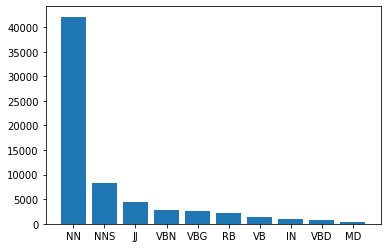

In [16]:
# Add part-of-speach tags
for w in range(len(words)):
  words.loc[w,'tag'] = nltk.pos_tag([words.word[w]])[0][1].replace('$', '')
print(words.head(5))
#print(words_stp.groupby('tag').tag.count())
plt.bar(words.tag.value_counts().sort_values(ascending=False)[:10].reset_index()['index'],words.tag.value_counts().sort_values(ascending=False)[:10].reset_index()['tag'])

### Phrases
https://www.nltk.org/book/ch07.html

In [ ]:
n=1
print(words[words.idx==n])
words[words.idx==n]

    idx  tgt    word    root tag
7     1    1  forest  forest  NN
8     1    1    fire    fire  NN
9     1    1    near    near  IN
10    1    1      la      la  NN
11    1    1   ronge    rong  NN
12    1    1    sask    sask  NN
13    1    1  canada  canada  NN


,idx,tgt,word,root,tag
7,1,1,forest,forest,NN
8,1,1,fire,fire,NN
9,1,1,near,near,IN
10,1,1,la,la,NN
11,1,1,ronge,rong,NN
12,1,1,sask,sask,NN
13,1,1,canada,canada,NN


In [ ]:
# To fix the tree.draw() error
#!apt-get install -y xvfb
import os
os.system("Xvfb :1 -screen 0 720x720x16 &")
os.environ['DISPLAY']=":1.0"

In [ ]:
# Phrases tokenizing - Chunking - combines words by part-of-speach
#grammar = "NP: {<DT>?<JJ>*<NN>}"
grammar = "NP: {<NN|NNS|VBG><NN|NNS>}"
chunk_parser = nltk.RegexpParser(grammar)
chunks = []
for i in range(words.idx.max()):
  s = words[words.idx==i].word
  tree = chunk_parser.parse(nltk.pos_tag(s))
  chunks.append(tree)
  for subtree in tree.subtrees():
    if subtree.label() == 'CHUNK': print(subtree)
#print(chunks)

In [ ]:
# Draw a tree
tree = chunk_parser.parse(nltk.pos_tag(s))
tree.draw()

In [ ]:
# Phrases tokenizing - Chinking - sequence of tokens that is not included in a chunk
grammar = """
 Chunk: {<.*>+}
        }<JJ>{"""
chunk_parser = nltk.RegexpParser(grammar)
chinks = []
for i in range(words.idx.max()):
  s = words[words.idx==i].word
  tree = chunk_parser.parse(nltk.pos_tag(s))
  chinks.append(tree)


### Long to wide

In [ ]:
# Count word appearance
words_cnt = words.copy()
words_cnt['word_cnt'] = words_cnt.groupby(['idx','tgt','word'])['word'].transform('count')
words_cnt['root_cnt'] = words_cnt.groupby(['idx','tgt','root'])['root'].transform('count')
words_cnt['word_cnt_tot'] = words_cnt.groupby(['word'])['word'].transform('count')
words_cnt['root_cnt_tot'] = words_cnt.groupby(['root'])['root'].transform('count')
words_cnt.head(3)

,idx,tgt,word,root,tag,word_cnt,root_cnt,word_cnt_tot,root_cnt_tot
0,0,1,deeds,deed,NNS,1,1,2,2
1,0,1,reason,reason,NN,1,1,15,26
2,0,1,earthquake,earthquak,NN,1,1,50,53


In [ ]:
# Drop words with low count 
n=5
word_w = words_cnt.loc[words_cnt.word_cnt_tot>n,['idx','tgt','word','word_cnt']].copy()
word_w = word_w.drop_duplicates()
word_w = word_w.pivot(index=['idx','tgt'],columns='word',values='word_cnt')
word_w = word_w.fillna(0)
word_w.shape
print(word_w.head(3))
# word_w.iloc[0].sum()

word     aba  abandoned  abc  ablaze  able  absolutely  abstorm  access  \
idx tgt                                                                   
0   1    0.0        0.0  0.0     0.0   0.0         0.0      0.0     0.0   
1   1    0.0        0.0  0.0     0.0   0.0         0.0      0.0     0.0   
2   1    0.0        0.0  0.0     0.0   0.0         0.0      0.0     0.0   

word     accident  accidentally  ...  yyc    z  zombie  zone   û  û  ûï  \
idx tgt                          ...                                          
0   1         0.0           0.0  ...  0.0  0.0     0.0   0.0  0.0  0.0  0.0   
1   1         0.0           0.0  ...  0.0  0.0     0.0   0.0  0.0  0.0  0.0   
2   1         0.0           0.0  ...  0.0  0.0     0.0   0.0  0.0  0.0  0.0   

word     ûïwhen  ûò  ûó  
idx tgt                     
0   1        0.0  0.0  0.0  
1   1        0.0  0.0  0.0  
2   1        0.0  0.0  0.0  

[3 rows x 2207 columns]


In [ ]:
# Drop words with low count (stemmed to roots)
n=5
root_w = words_cnt.loc[words_cnt.word_cnt_tot>n,['idx','tgt','word','word_cnt']].copy()
root_w = root_w.drop_duplicates()
root_w = root_w.pivot(index=['idx','tgt'],columns='word',values='word_cnt')
root_w = root_w.fillna(0)
root_w.shape
print(root_w.head(3))
# root_w.iloc[0].sum()

word     aba  abandoned  abc  ablaze  able  absolutely  abstorm  access  \
idx tgt                                                                   
0   1    0.0        0.0  0.0     0.0   0.0         0.0      0.0     0.0   
1   1    0.0        0.0  0.0     0.0   0.0         0.0      0.0     0.0   
2   1    0.0        0.0  0.0     0.0   0.0         0.0      0.0     0.0   

word     accident  accidentally  ...  yyc    z  zombie  zone   û  û  ûï  \
idx tgt                          ...                                          
0   1         0.0           0.0  ...  0.0  0.0     0.0   0.0  0.0  0.0  0.0   
1   1         0.0           0.0  ...  0.0  0.0     0.0   0.0  0.0  0.0  0.0   
2   1         0.0           0.0  ...  0.0  0.0     0.0   0.0  0.0  0.0  0.0   

word     ûïwhen  ûò  ûó  
idx tgt                     
0   1        0.0  0.0  0.0  
1   1        0.0  0.0  0.0  
2   1        0.0  0.0  0.0  

[3 rows x 2207 columns]


### Keyword extraction

In [ ]:
sent.head()

,text,clean_tweet
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo rubi alaska smoke wildfir pour ...


In [ ]:
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet.lower())

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet.lower())  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet.lower())   

In [ ]:
# make new columns for retweeted usernames, mentioned usernames and hashtags
sent['retweeted'] = sent.text.apply(find_retweeted)
sent['mentioned'] = sent.text.apply(find_mentioned)
sent['hashtags'] = sent.text.apply(find_hashtags)

In [ ]:
# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = sent.loc[
                       sent.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

# create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
print(flattened_hashtags_df.head(3))

       hashtag
0  #earthquake
1   #wildfires
2      #alaska


In [ ]:
# number of unique hashtags
print('N unique hashtags ',flattened_hashtags_df['hashtag'].unique().size)
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
print(popular_hashtags.head(3))

N unique hashtags  1875
  hashtag  counts
0   #news      76
1    #hot      31
2   #best      30


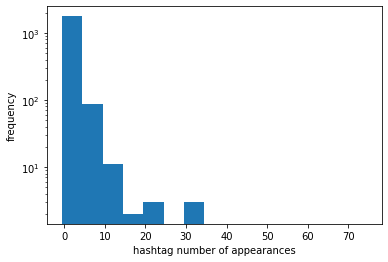

In [ ]:
# number of times each hashtag appears
counts = flattened_hashtags_df.groupby(['hashtag']).size()\
                              .reset_index(name='counts')\
                              .counts

# define bins for histogram                              
my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure()
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [ ]:
counts.head()

0    2
1    1
2    1
3    1
4    2
Name: counts, dtype: int64

## Save ds

In [ ]:
# Save dfs
# sent.to_csv("data/sent.csv")
# words.to_csv("data/words.csv")
# word_w.to_csv("data/word_w.csv")
# root_w.to_csv("data/root_w.csv")

## Describe

<BarContainer object of 2 artists>

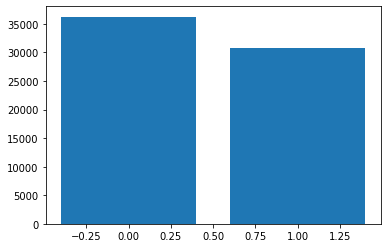

In [ ]:
# Target var
plt.bar(words.tgt.value_counts().index,words.tgt.value_counts())

[('like', 407), ('fire', 361), ('amp', 344), ('get', 311), ('bomb', 238), ('new', 222), ('via', 220), ('one', 207), ('peopl', 200), ('go', 200)]


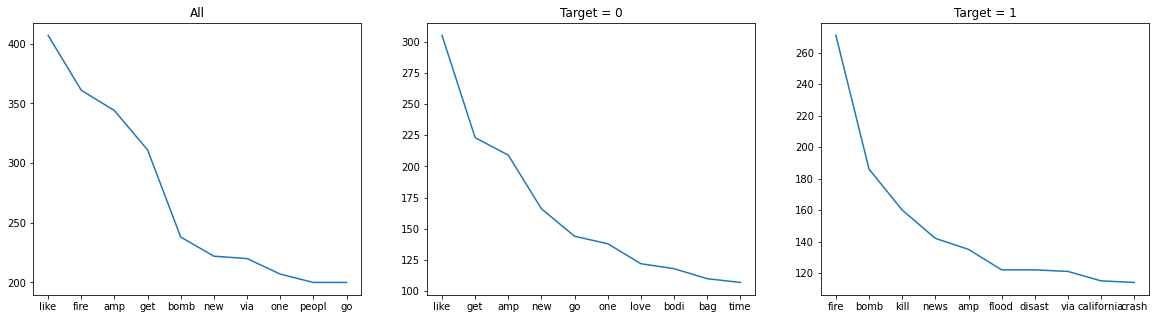

In [ ]:
# Words frequencies
#fdist = FreqDist(words.word)
fdist = FreqDist(words.root)
fdist0 = FreqDist(words[words.tgt==0].root)
fdist1 = FreqDist(words[words.tgt==1].root)
print(fdist.most_common(10))

fig = plt.figure(figsize=(20, 5))
gs = GridSpec(nrows=1, ncols=3)

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot([fdist.most_common(10)[x][0] for x in range(10)],[fdist.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("All")

ax0 = fig.add_subplot(gs[0, 1])
ax0.plot([fdist0.most_common(10)[x][0] for x in range(10)],[fdist0.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("Target = 0")

ax0 = fig.add_subplot(gs[0, 2])
ax0.plot([fdist1.most_common(10)[x][0] for x in range(10)],[fdist1.most_common(10)[x][1] for x in range(10)])
ax0.title.set_text("Target = 1")

plt.show()

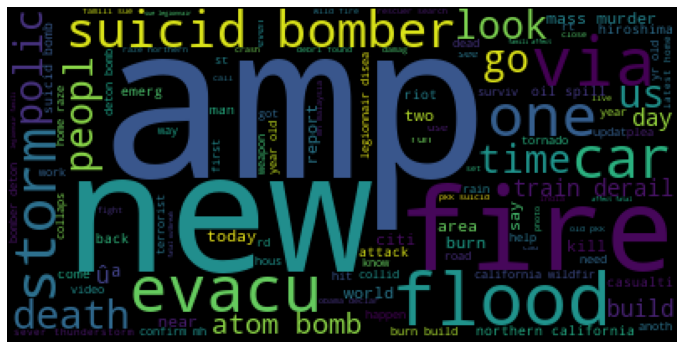

In [ ]:
# Cloud of words
wordcloud = WordCloud().generate(" ".join(words[words.tgt==1].root))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Check https:
http = []
for i in range(len(data)):
  if 'http' in data.text[i]:
    http.append(data.text[i])
#http

In [ ]:
# Hashtag correlation
# take hashtags which appear at least this amount of times
min_appearance = 10
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

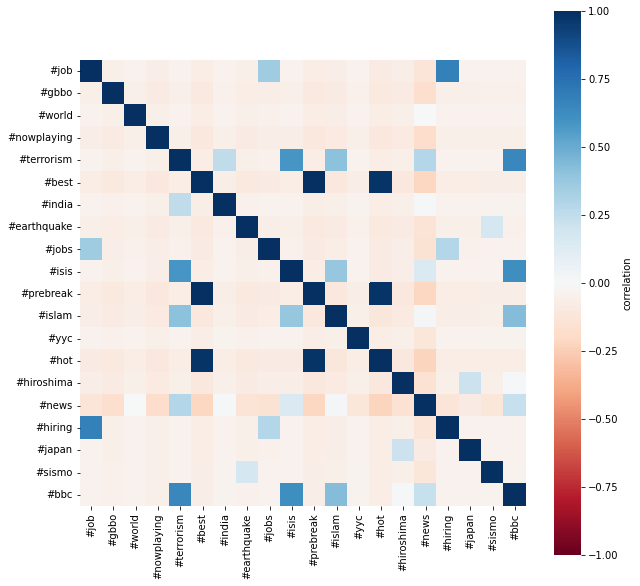

In [ ]:
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)
# calculate the correlation matrix
correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()

## Frequencies

In [ ]:
# reference: Natural Language Processing with Classification and Vector Spaces by DeepLearning.AI
def build_freqs(tweets, ys):
    """Build frequencies.
    Input:
        tweets: a list of tweets
        ys: an m x 1 array with the sentiment label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(ys).tolist()

    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in word_tokenize(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs

In [ ]:
build_freqs(sent.clean_tweet_root, data.target)

In [ ]:
# create frequency dictionary
freqs = build_freqs(sent.clean_tweet_root, data.target)

# check data type
print(f'type(freqs) = {type(freqs)}')
# check length of the dictionary
print(f'len(freqs) = {len(freqs)}')

type(freqs) = <class 'dict'>
len(freqs) = 14790


In [ ]:
# Visualise the frequencies

# select some words to appear in the report
keys = [i[0] for i in fdist.most_common(20)]

# list representing our table of word counts.
# each element consist of a sublist with this pattern: [<word>, <positive_count>, <negative_count>]
report = []

# loop through selected words
for word in keys:
    
    # initialize positive and negative counts
    pos = 0
    neg = 0
    
    # retrieve number of positive counts
    if (word, 1) in freqs:
        pos = freqs[(word, 1)]
        
    # retrieve number of negative counts
    if (word, 0) in freqs:
        neg = freqs[(word, 0)]
        
    # append the word counts to the table
    report.append([word, pos, neg])
    
report

[['like', 102, 305],
 ['fire', 271, 90],
 ['amp', 135, 209],
 ['get', 88, 223],
 ['bomb', 186, 52],
 ['new', 56, 166],
 ['via', 121, 99],
 ['one', 69, 138],
 ['peopl', 106, 94],
 ['go', 56, 144],
 ['news', 142, 57],
 ['time', 73, 107],
 ['burn', 86, 93],
 ['year', 112, 66],
 ['kill', 160, 18],
 ['video', 72, 102],
 ['flood', 122, 47],
 ['emerg', 80, 84],
 ['crash', 114, 50],
 ['disast', 122, 39]]

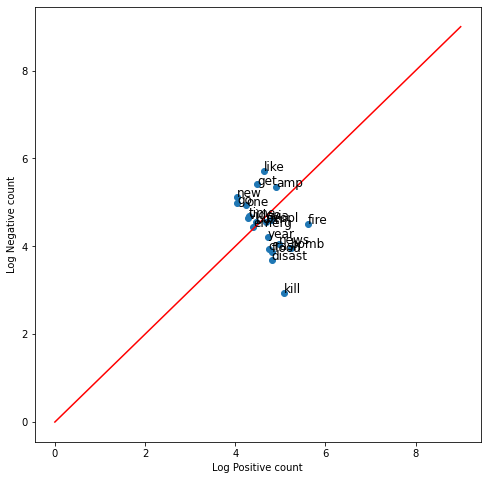

In [ ]:
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in report])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in report]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(report)):
    ax.annotate(report[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()